***(i) Import the function from the module "mzprojection"***

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mzprojection import mzprojection_multivariate_discrete_time, split_long_time_series, calc_correlation
from mzprojection import mzprojection_regression

help(mzprojection_multivariate_discrete_time)
help(mzprojection_regression)

Help on function mzprojection_multivariate_discrete_time in module mzprojection.mzprojection:

mzprojection_multivariate_discrete_time(u, f, flag_terms=False, flag_debug=False)
    Evaluate discrete-time M-Z projection of f(t_n) on u(t_n),
      f_i(t_n) = Omega_ij*u_j(t_n) - \sum_{l=0}^{n-1} Gamma_ij(t_l)*u_j(t_{n-l}) + r_i(t_n)
    taking summation over the repeated index j.
    
    Parameters
    ----------
    u[nsample,nperiod,nu] : Numpy array (float64 or complex128)
        Explanatory variable u_j(t_n).
        nsample is the number of samples.
        nperiod is the number of time steps of a short-time data.
        nu is the number of independent explanatory variable (j=0,1,...,nu-1).
    f[nsample,nperiod,nf] : Numpy array (float64 or complex128)
        Response variable f_i(t).
        nf is the number of independent response variables (i=0,1,...,nf-1).
        If 2D array f[nsample,nperiod] is passed, it is treated as 3D array with nf=1.
    flag_terms : bool
        Con

***(ii) Prepare ensemble of time series data***  
Here, we split a long time-series data of statistically steady state into a number of samples of short-time data.

t_raw[:].shape= (20000,)
u_raw[:,nu].shape= (20000, 18)
f_raw[:,nf].shape= (20000, 18) # nu/=nf is available.


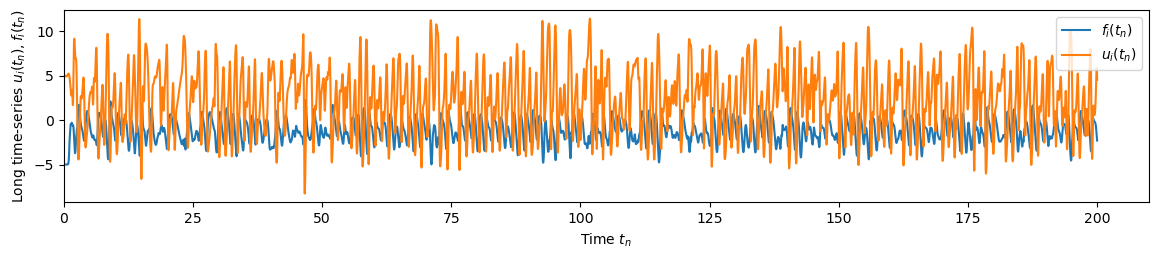

In [2]:
#= Read sample data =
ds = xr.open_dataset('../sample_data/sample_multivariate_L96xy.nc')
t_raw    = np.array(ds.t)      # Time t
u_raw    = np.array(ds.u).T    # Variable of interest u(t)
f_raw    = np.array(ds.f).T    # Analyzed data f(t)
print("t_raw[:].shape=",t_raw.shape)
print("u_raw[:,nu].shape=",u_raw.shape)
print("f_raw[:,nf].shape=",f_raw.shape,"# nu/=nf is available.")

fig = plt.figure(figsize=(14,2.5))
ax = fig.add_subplot(111)
ax.set_xlabel("Time $t_n$")
ax.set_ylabel("Long time-series $u_i(t_n), f_i(t_n)$")
ax.plot(t_raw,f_raw[:,0],label="$f_i(t_n)$")
ax.plot(t_raw,u_raw[:,0],label="$u_i(t_n)$")
ax.set_xlim(0,None)
plt.legend()
plt.show()

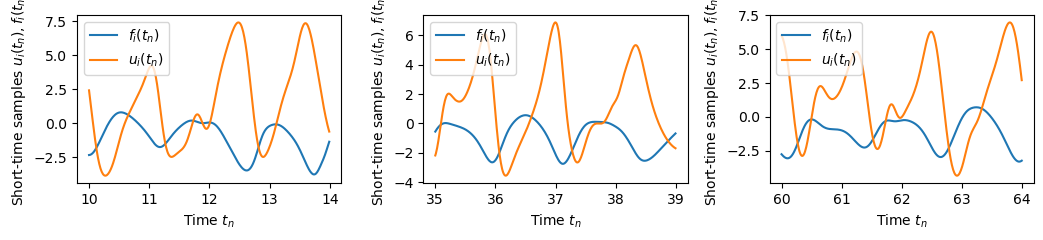

In [3]:
#= Split a long time series data into samples of short-time data =
ista    = 1000                # Start time step number for sampling   
nperiod = 400                 # Time step length of a short-time sample                 
nshift  = 10                  # Length of time shift while sampling
t   =split_long_time_series(t_raw,ista=ista,nperiod=nperiod,nshift=nshift)
u   =split_long_time_series(u_raw,ista=ista,nperiod=nperiod,nshift=nshift)
f   =split_long_time_series(f_raw,ista=ista,nperiod=nperiod,nshift=nshift)

fig = plt.figure(figsize=(14,2.5))
samples = [0,250,500]
for i in range(len(samples)):
    ax = fig.add_subplot(int("14{:}".format(i+1)))
    isample = samples[i]
    ax.set_xlabel(r"Time $t_n$")
    ax.set_ylabel(r"Short-time samples $u_i(t_n), f_i(t_n)$")
    ax.plot(t[isample,:],f[isample,:,0],label=r"$f_i(t_n)$")
    ax.plot(t[isample,:],u[isample,:,0],label=r"$u_i(t_n)$")
    ax.legend()
fig.tight_layout()
plt.show()

# Check the consistency between the regression-based projection operator method and Mori's linear projection operator method.

***(iii) Apply the Moti's linear projection operator method***  
The projection of $\boldsymbol{f}(t)$ on $\boldsymbol{u}(t)$ is calculated as,  
    $\boldsymbol{f}(t_n)=\Omega \cdot \boldsymbol{u}(t_n)+\boldsymbol{s}(t_n)+\boldsymbol{r}(t_n)$,  
    $\boldsymbol{s}(t)=-\sum_{l=1}^n \Gamma(t_l) \cdot \boldsymbol{u}(t_{n-l})$.  
The Markov coefficient $\Omega$ and the memory function $\Gamma(t)$ are matrices.

In [4]:
omega, memoryf, s, r = mzprojection_multivariate_discrete_time(u, f, flag_terms=True, flag_debug=True)
t_cor = t_raw[0:memoryf.shape[0]]

nsample= 1861 , nperiod= 400 , nu= 18 , nf= 18
# Elapsed time to prepare correlations [sec]: 0.48819661140441895
      uu0_inv[nu,nu].shape= (18, 18) float64
    G[nperiod,nu,nu].shape= (400, 18, 18) float64
      wG0_inv[nu,nu].shape= (18, 18) float64
# Elapsed time to calc. omega & memoryf [sec]: 0.5684220790863037
          omega[nf,nu].shape= (18, 18) float64
memoryf[nperiod,nf,nu].shape= (400, 18, 18) float64
# Elapsed time to calc. residual r [sec]: 3.362788677215576
s[nsample,nperiod,nf].shape= (1861, 400, 18) float64
r[nsample,nperiod,nf].shape= (1861, 400, 18) float64


***(iv) Apply the regression-based projection operator method***  
The regression-based M-Z projection of $\boldsymbol{f}(t)$ on $\boldsymbol{g}(t)$ in a discrete-time system is calculated as,  
    $\boldsymbol{f}(t_n)=\Omega[\boldsymbol{g}(t_n)]+\boldsymbol{s}(t_n)+\boldsymbol{r}(t_n)$,    
    $\boldsymbol{s}(t)=\sum_{l=1}^{n-1} \Gamma(t_l)[\boldsymbol{g}(t_{n-l})]$.   
The Markov relation $\Omega$ is a nonlinear vector function of $\boldsymbol{g}$. The memory kernel $\Gamma(t_l)$ is a time-dependent nonlinear vector function of $\boldsymbol{g}$. The uncorrelated term $\boldsymbol{r}(t_n)$ is orthogonal to the projection, $P[\boldsymbol{r}(t_n)]=0$ for any $t_n$.

Just for numerical convenience, we define $\Gamma(0) \equiv \Omega$. Then, the equation is  
    $\boldsymbol{f}(t_n) = \sum_{l=0}^{n-1} \Gamma(t_l)[\boldsymbol{g}(t_{n-l})] + \boldsymbol{r}(t_n)$.

The regression-based projection operator method assumes the projection operator $P$ is a regression on $\boldsymbol{g}(0)$, e.g., $P[\boldsymbol{f}(t)]=P[\boldsymbol{f}(t) | \boldsymbol{g}(0)]$. To check the consistency with the Mori's linear projection, we consider the linear regression, $\boldsymbol{f}(t) = A \cdot \boldsymbol{g}(0)$, then, $\Omega[\boldsymbol{g}] \rightarrow \Omega \cdot \boldsymbol{g}$ and $\Gamma(t_l)[\boldsymbol{g}(t_{n-l})] \rightarrow \Gamma(t_l) \cdot \boldsymbol{g}(t_{n-l})$.

In [5]:
omega_reg, gamma_reg, s_reg, r_reg = mzprojection_regression(u,f,regression_type="linear_wo_origin",flag_terms=True,flag_debug=True)

nsample= 1861 , nperiod= 400 , ng= 18 , nf= 18
# Elapsed time to calc. Markov relation [sec]: 0.18823552131652832
# Elapsed time to calc. memory kernel [sec]: 64.97337222099304
# Elapsed time to calc. residual r [sec]: 71.22978448867798
s[nsample,nperiod,nf].shape= (1861, 400, 18) float64
r[nsample,nperiod,nf].shape= (1861, 400, 18) float64


***(iii) Apply the Moti's linear projection operator method***  
The projection of $\boldsymbol{f}(t)$ on $\boldsymbol{u}(t)$ is calculated as,  
    $\boldsymbol{f}(t_n)=\Omega \cdot \boldsymbol{u}(t_n)+\boldsymbol{s}(t_n)+\boldsymbol{r}(t_n)$,  
    $\boldsymbol{s}(t)=-\sum_{l=1}^n \Gamma(t_l) \cdot \boldsymbol{u}(t_{n-l})$.  
The Markov coefficient $\Omega$ and the memory function $\Gamma(t)$ are matrices.

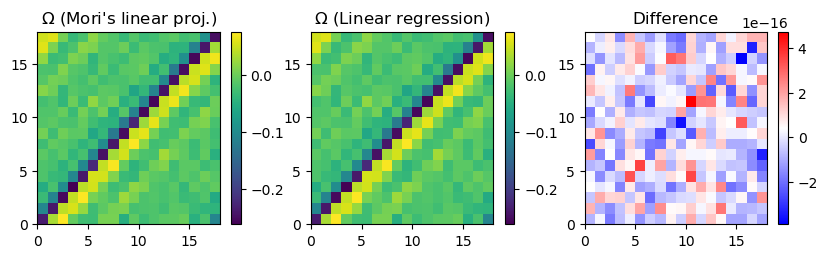

In [6]:
# print(omega)
# print(omega_reg.matA())

fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(131)
quad=ax.pcolormesh(omega[:,:])
ax.set_title(r"$\Omega$ (Mori's linear proj.)")
fig.colorbar(quad)
ax = fig.add_subplot(132)
quad=ax.pcolormesh(omega_reg.matA()[:,:])
ax.set_title(r"$\Omega$ (Linear regression)")
fig.colorbar(quad)
ax = fig.add_subplot(133)
quad=ax.pcolormesh(omega - omega_reg.matA()[:,:],cmap="bwr")
ax.set_title(r"Difference")
fig.colorbar(quad)
plt.show()

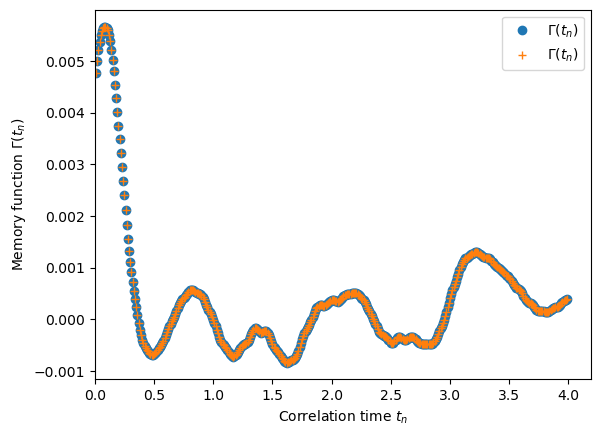

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Correlation time $t_n$")
ax.set_ylabel(r"Memory function $\Gamma(t_n)$")
ax.plot(t_cor[1:],memoryf[1:,2,2],"o",label=r"$\Gamma(t_n)$")
ax.plot(t_cor[1:],[-g.matA()[2,2] for g in gamma_reg[1:]],"+",label=r"$\Gamma(t_n)$")
ax.set_xlim(0,None)
plt.legend()
plt.show()

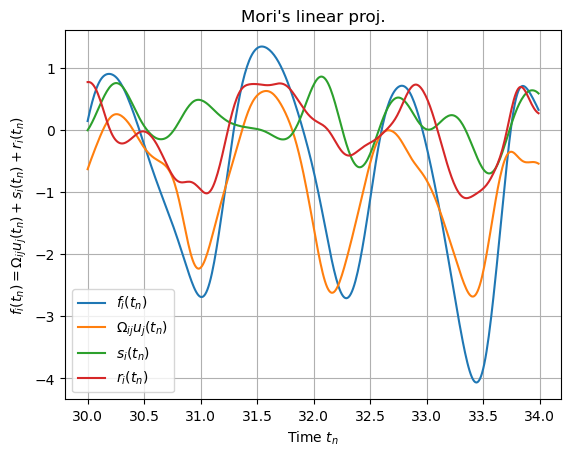

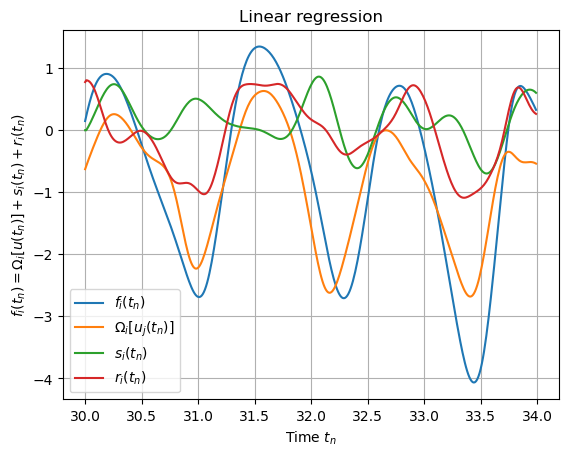

In [8]:
isample=200

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"Mori's linear proj.")
ax.set_xlabel(r"Time $t_n$")
ax.set_ylabel(r"$f_i(t_n)=\Omega_{ij}u_j(t_n)+s_i(t_n)+r_i(t_n)$")
ax.plot(t[isample,:],f[isample,:,0],label=r"$f_i(t_n)$")
ax.plot(t[isample,:],np.dot(u[isample,:,:],omega.T)[:,0],label=r"$\Omega_{ij}u_j(t_n)$")
ax.plot(t[isample,:],s[isample,:,0],label=r"$s_i(t_n)$")
ax.plot(t[isample,:],r[isample,:,0],label=r"$r_i(t_n)$")
ax.grid()
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"Linear regression")
ax.set_xlabel(r"Time $t_n$")
ax.set_ylabel(r"$f_i(t_n)=\Omega_{i}[u(t_n)]+s_i(t_n)+r_i(t_n)$")
ax.plot(t[isample,:],f[isample,:,0],label=r"$f_i(t_n)$")
ax.plot(t[isample,:],omega_reg.fit(u[isample,:,:])[:,0],label=r"$\Omega_{i}[u_j(t_n)]$")
ax.plot(t[isample,:],s_reg[isample,:,0],label=r"$s_i(t_n)$")
ax.plot(t[isample,:],r_reg[isample,:,0],label=r"$r_i(t_n)$")
ax.grid()
ax.legend()
plt.show()